In [1]:
# %pip install numpy scipy matplotlib

In [1]:
import numpy as np
from scipy.signal import convolve, deconvolve, windows
import matplotlib.pyplot as plt

In [149]:
spks = np.load("data/spks.npy")
spike_trace = spks[11]
spike_train = (spike_trace > 0.00005).astype(int)

This notebook will help you understand how calcium imaging signals are created and how to work with them. You will learn how neural spikes turn into calcium fluorescence signals using a process called convolution. Later, you will try to recover those spikes from the fluorescence signals using deconvolution. 

The models and exercises use basic Python tools such as `numpy`, `scipy`, and `matplotlib`.

### General Convolution (No Calcium Kernel)

In this section, you will learn how a basic convolution works. A spike train is a list of ones and zeros that shows when a neuron is active. When you convolve this with a simple filter, the result becomes a smooth signal. This helps you see how raw spike data turns into a shape that looks more like a calcium trace. This section does not use real calcium biology yet—it just helps build the foundation.


Convolution is a way to smooth or blur a signal by sliding a small pattern across it and combining nearby values. It involves two main ideas:
- **Kernel**: A small pattern or filter that defines how the input values are combined. For example, a *boxcar kernel* gives equal weight to all values within a certain range. Other kernels can give more weight to recent values and less to older ones.
- **Window**: The size or width of the kernel — that is, how many time points the kernel covers. A wider window includes more points and creates more smoothing; a smaller window preserves more detail.

In this section, let us explore the effect of different kernels and windows.

When we convolve a spike train with a kernel, each spike is spread out across time, producing a smoother signal.

The **size of the window** affects the result for `boxcar` kernel:
- A **small window** keeps spikes sharp and close to their original timing.
- A **medium window** smooths out nearby spikes into broader bumps.
- A **large window** flattens the signal and removes fine details.

**Example** Plot boxcar kernel with window length 5

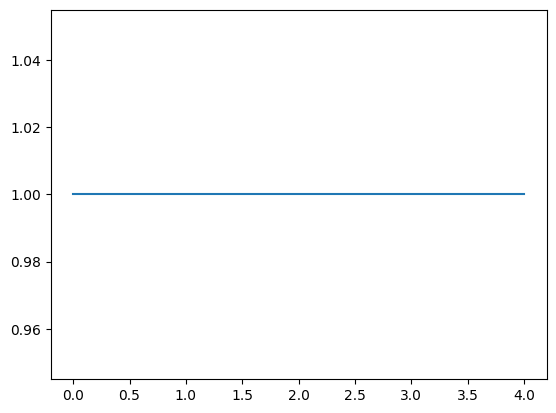

In [106]:
kernel = windows.boxcar(5)
plt.plot(kernel)

Plot boxcar kernel with window length 2

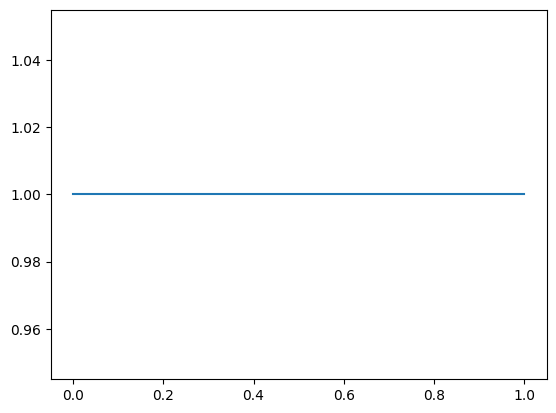

In [113]:
kernel = windows.boxcar(2)
plt.plot(kernel)

Plot boxcar kernel with window length 1


When we create a boxcar kernel with a window size of 1, it only contains a single value. This means the kernel is just `[1.0]`, with no other points before or after it. 

When we try to plot it using `plt.plot()`, it does not look like a curve or a line because there is only one point to show. That is why the plot appears empty or flat — we need at least two points to see a visible shape.

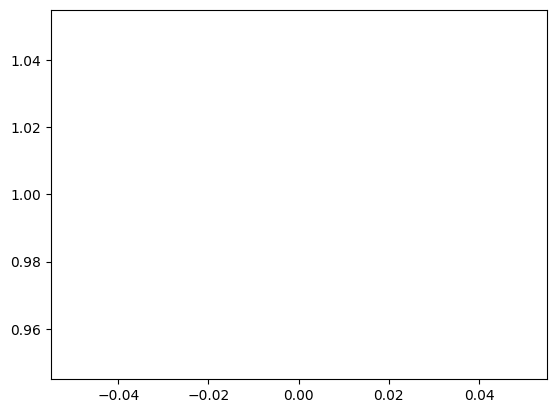

In [110]:
kernel = windows.boxcar(1)
plt.plot(kernel)

**Example** Convolve with window length 5

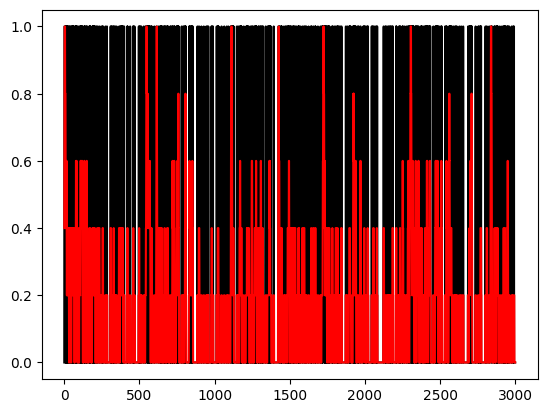

In [186]:
kernel_unnorm = windows.boxcar(5)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 25

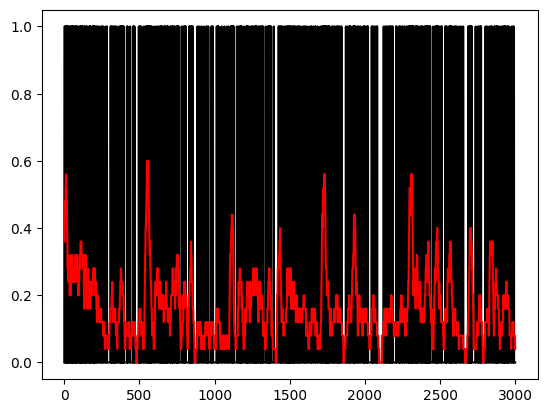

In [187]:
kernel_unnorm = windows.boxcar(25)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 1000

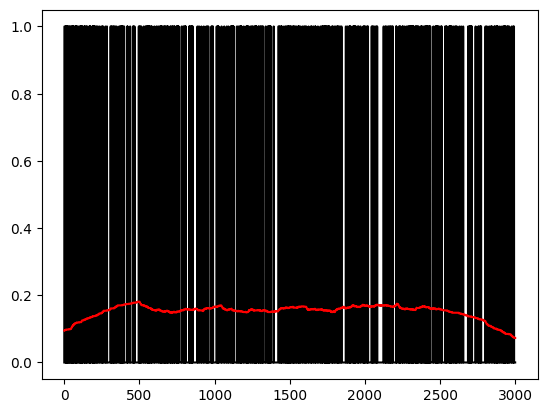

In [188]:
kernel_unnorm = windows.boxcar(1000)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 1

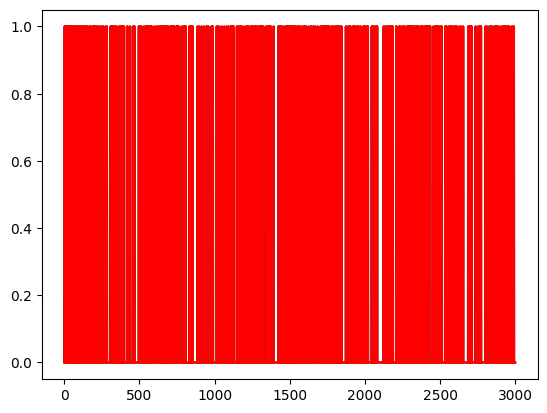

In [189]:
kernel_unnorm = windows.boxcar(1)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Now that we have seen how the window size affects the result of convolution, let us also look at how the **shape of the kernel** changes the output.

A **triangular kernel** gives more importance to the center of the window and less to the edges. This creates a smoother and softer curve. It can help show the overall pattern of spikes without adding too much noise.

A **boxcar kernel** gives equal importance to every point in the window. This can create more sharp changes in the signal and often shows more small peaks. However, these extra peaks can sometimes be noisy or less meaningful.

Even when both kernels use the same window size, they behave differently. The triangular kernel smooths gently, while the boxcar kernel can make the signal look more jagged.

**Example** Plot triangular kernel with window 25

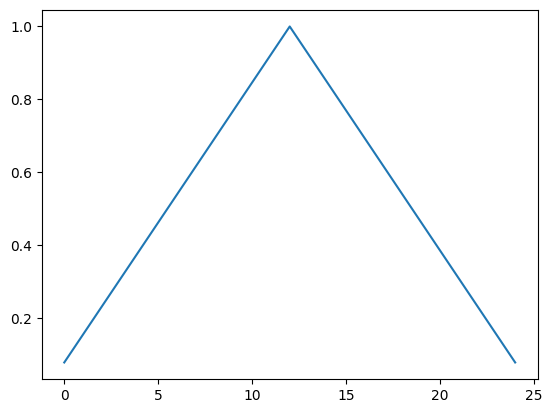

In [115]:
kernel = windows.triang(25)
plt.plot(kernel)

Plot triangular kernel with window 26

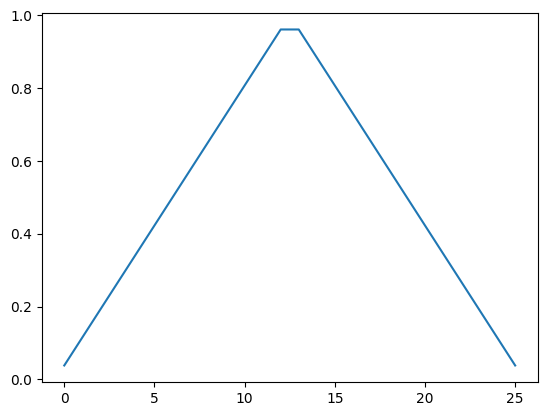

In [116]:
kernel = windows.triang(26)
plt.plot(kernel)

When we use an **even window length** for the triangular kernel, the peak of the triangle is spread across two values in the center instead of having a single sharp peak. This creates a small flat region at the top of the kernel. Instead of producing a smooth, pointed response around each spike, the convolution may produce a response that is slightly broader and flatter at the top. This can reduce the precision of peak locations in the output, especially when dealing with closely spaced spikes. For cleaner and more symmetric smoothing, it is usually better to use an **odd window length** for triangular kernels.

**Example** Convolve with triangular kernel (window=25)

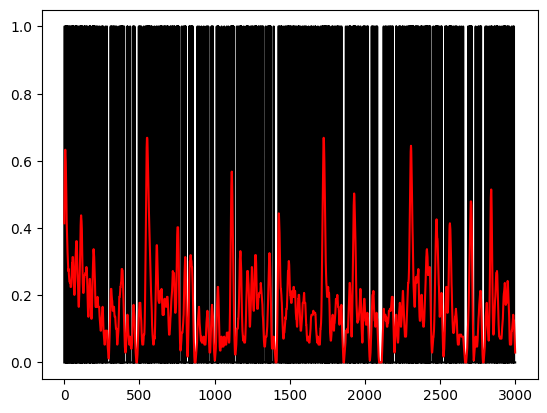

In [190]:
kernel_unnorm = windows.triang(25)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with triangular kernel (window=1001)

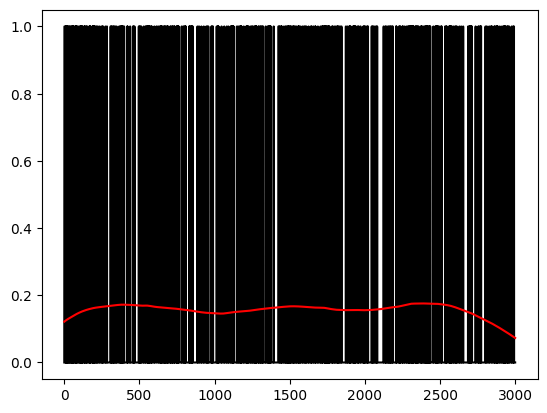

In [191]:
kernel_unnorm = windows.triang(1001)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Compare with triangular kernel and rectangular kernel (window=501)

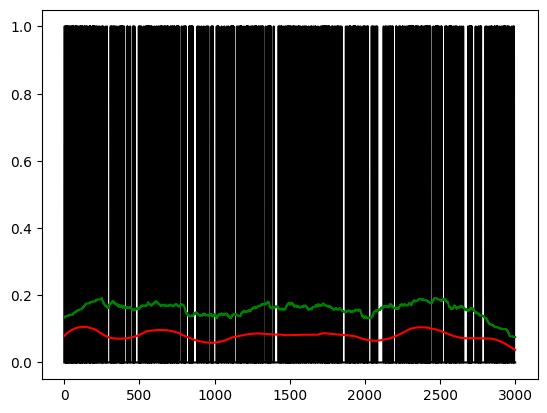

In [ ]:
kernel_tri_unnorm= windows.triang(501)
kernel_tri = kernel_tri_unnorm / kernel_unnorm.sum()

kernel_box_unnorm = windows.boxcar(501)
kernel_box = kernel_box_unnorm / kernel_unnorm.sum()

convolved_trace_tri = convolve(spike_train, kernel_tri, mode='same')
convolved_trace_box = convolve(spike_train, kernel_box, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace_tri, color='r')
plt.plot(convolved_trace_box, color='g')

The **Gaussian kernel** is a smooth, bell-shaped curve controlled by two key parameters: the **window length**, which sets how many points the kernel covers, and the **standard deviation**, which determines how wide or narrow the bell curve is inside that window.

A small standard deviation produces a sharp, narrow curve that focuses on local values, while a large standard deviation spreads the weights more evenly across the window, leading to heavier smoothing. 

**Example** Plot a gaussian kernel with window length 25 and std=1

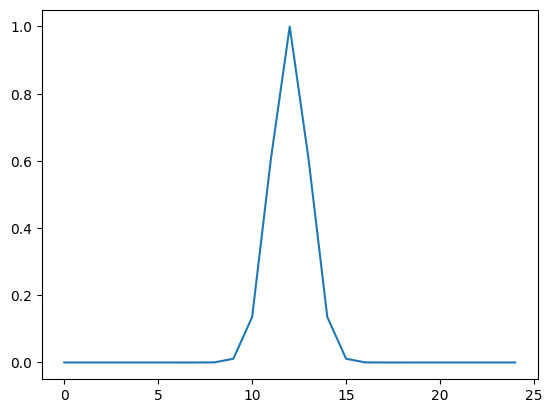

In [119]:
kernel = windows.gaussian(25, std=1)
plt.plot(kernel)

Plot a gaussian kernel with window length 25 and std=15

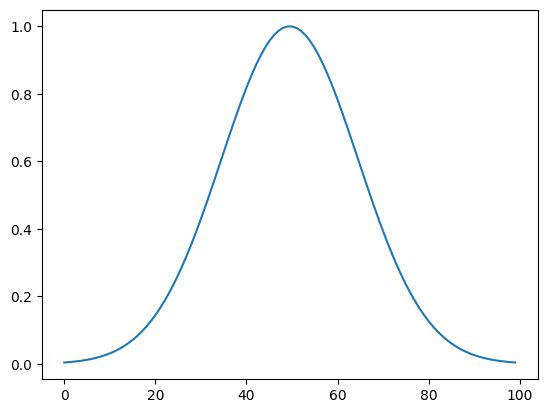

In [120]:
kernel = windows.gaussian(100, std=15)
plt.plot(kernel)

Plot a gaussian kernel with window length 200 and std=100

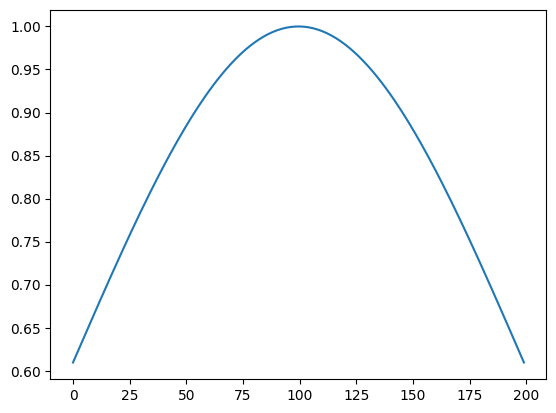

In [127]:
kernel = windows.gaussian(200, std=100)
plt.plot(kernel)

Convolve with gaussian kernel (window=25, std=1)

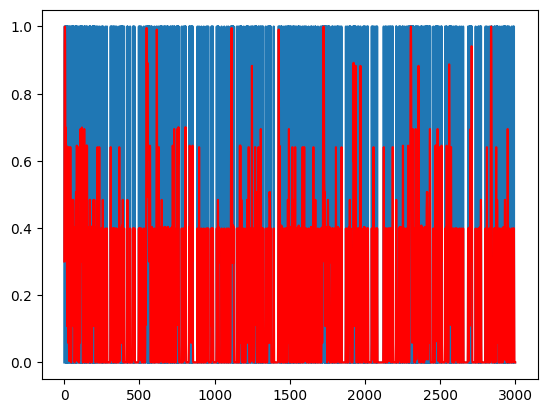

In [194]:
kernel_unnorm = windows.gaussian(25, std=1)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

Convolve with gaussian kernel (window=100, std=15)

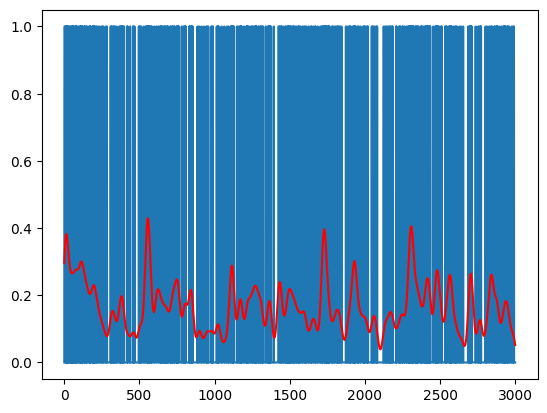

In [195]:
kernel_unnorm = windows.gaussian(100, std=15)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

Convolve with gaussian kernel (window=200, std=100)

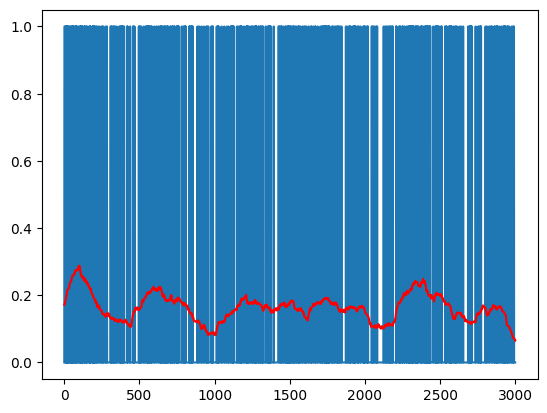

In [196]:
kernel_unnorm = windows.gaussian(200, std=100)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

### Convolution with Calcium Spike Transient Kernel

Now you will make your model more realistic. Calcium signals do not rise and fall instantly. Instead, they rise quickly after a spike and then decay slowly. You will use a calcium kernel that mimics this behavior. When you convolve this kernel with a spike train, you will get a signal that looks more like what you see in real experiments. 


The **exponential decay kernel** models the calcium signal that follows a spike. It starts with a high value and then decreases smoothly over time, capturing the way calcium levels rise quickly and then slowly fall back down after neural activity.

This kernel is controlled by a single parameter called the **decay time constant** (tau), which determines how quickly the signal fades. A small tau produces a fast decay, while a large tau causes the signal to fall more slowly. To apply this decay over time, we use an array `t` to represent each time step after a spike. The equation `exp(-t / tau)` tells us how much the signal should decrease at each step. The unit of tau depends on the data: in synthetic simulations, it is measured in time steps or samples, while in real calcium imaging data, tau is measured in **frames** and can be converted into seconds using the sampling rate (frames per second).

**Example** Plot exponential decay kernel (tau = 5, length = 100)

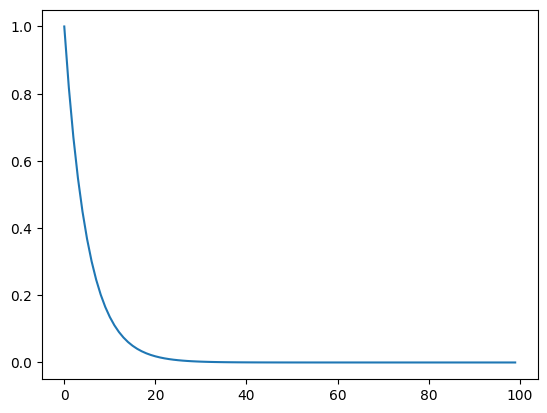

In [130]:
tau = 5
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)
plt.plot(kernel)

Plot exponential decay kernel (tau = 20, length = 100)

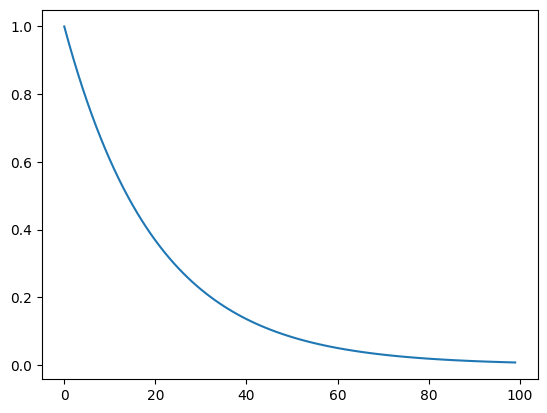

In [131]:
tau = 20
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)
plt.plot(kernel)

Plot exponential decay kernel (tau = 50, length = 100)

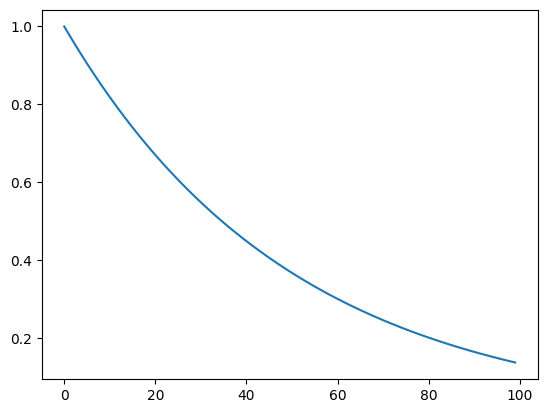

In [163]:
tau = 50
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)

plt.plot(kernel)

**Example** Convolve with exponential decay calcium transient (tau=20, window=100)

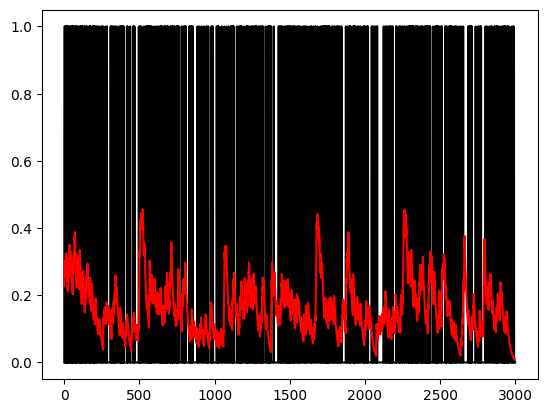

In [179]:
tau = 20
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with exponential decay calcium transient (tau=50, window=100)

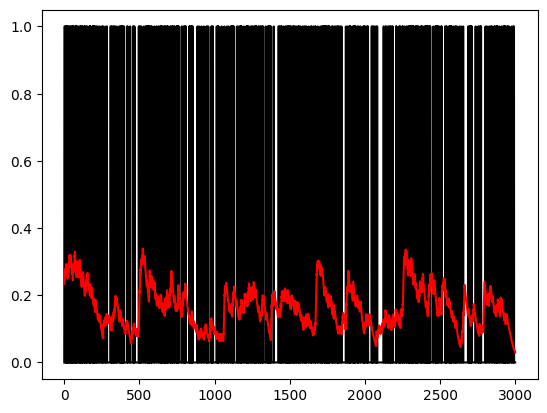

In [180]:
tau = 50
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with exponential decay calcium transient (tau=5, window=100)

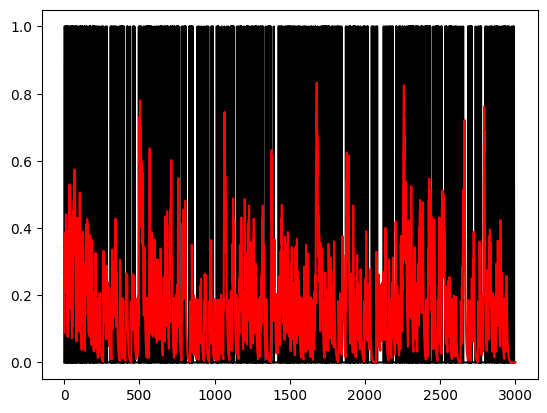

In [181]:
tau = 5
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

The **double exponential decay kernel** gives a more realistic model of calcium transients than the single exponential. Instead of assuming an immediate rise after a spike, it captures both the rise and decay phases using two time constants:
- **tau_rise** controls how quickly the signal increases after a spike.
- **tau_decay** controls how slowly it fades back down.

The kernel is defined as the difference between two exponential functions — one for the decay and one for the rise:

    k(t) = exp(-t / tau_decay) - exp(-t / tau_rise)

The result is a curve that starts at zero, rises quickly to a peak, and then decays gradually — similar to how calcium signals behave in real imaging data.

Let us see the effect of `tau_decay`, `tau_rise`, and their combination affects the kernel shape and eventually, our convolved trace.

Increasing `tau_rise` makes the kernel rise more slowly, delaying the peak and smoothing the initial slope.

A smaller `tau_rise` creates a sharper, faster onset, which better resembles the quick calcium increase after a spike in real data.

**Example** Plot double exponential kernel (rise=3, decay=30)

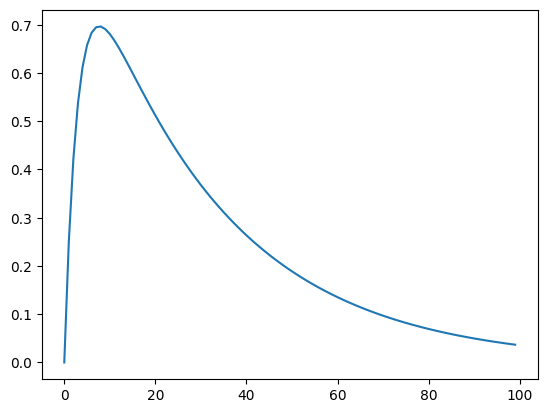

In [199]:
tau_rise = 3
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=10, decay=30)

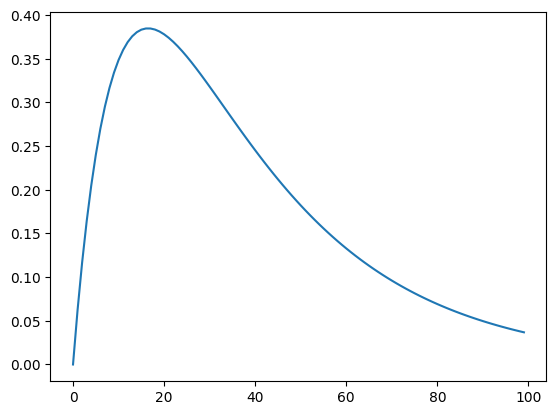

In [200]:
tau_rise = 10
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=20, decay=30)

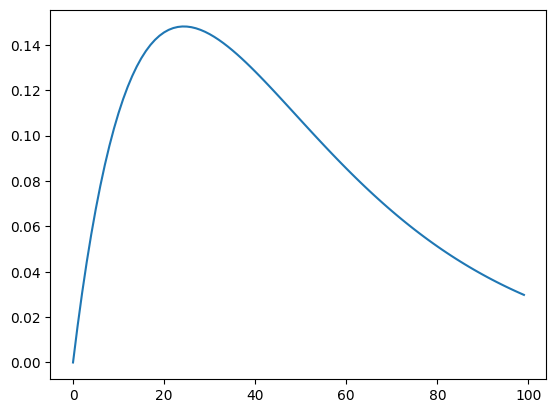

In [201]:
tau_rise = 20
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Increasing `tau_decay` makes the kernel decay more slowly, stretching the signal over a longer period.

A smaller `tau_decay` causes the signal to fall quickly, resulting in a shorter-lasting transient.

Plot double exponential kernel (rise=5, decay=20)

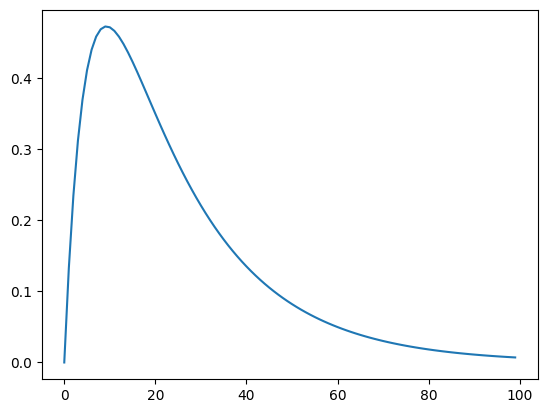

In [203]:
tau_rise = 5
tau_decay = 20
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=5, decay=40)

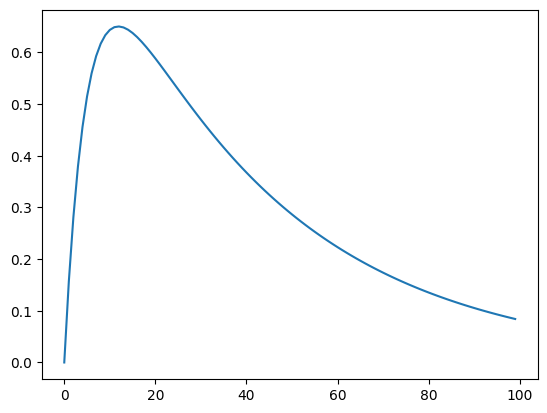

In [204]:
tau_rise = 5
tau_decay = 40
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=5, decay=80)

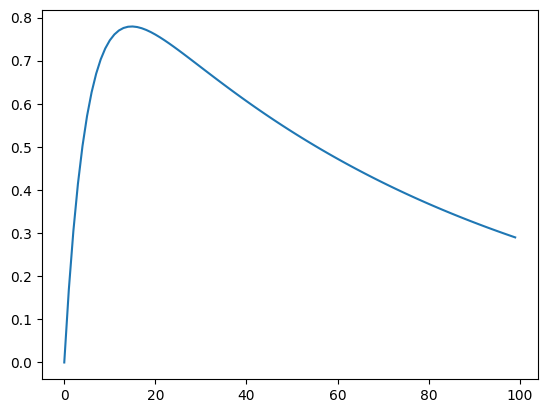

In [205]:
tau_rise = 5
tau_decay = 80
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

When `tau_rise` is greater than `tau_decay`, the kernel becomes invalid for calcium modeling — it may start negative or have no clear rise.

When `tau_rise` equals `tau_decay`, the two exponentials cancel each other out and the kernel becomes flat (zero everywhere).

To create a realistic calcium transient, `tau_rise`<`tau_decay`. This ensures a fast rise and slow decay, matching the typical shape of calcium signals after a spike.

Plot double exponential kernel (rise=20, decay=20)

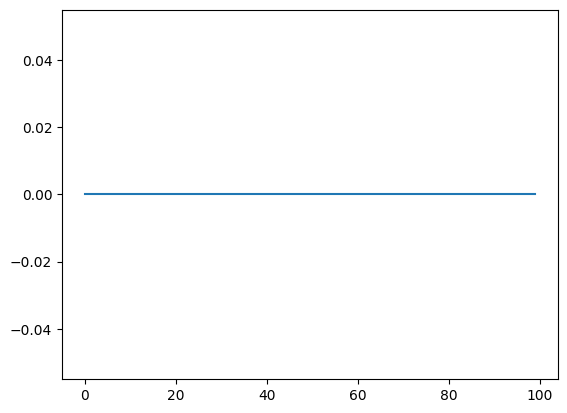

In [206]:
tau_rise = 20
tau_decay = 20
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
plt.plot(kernel)

Plot double exponential kernel (rise=20, decay=10)

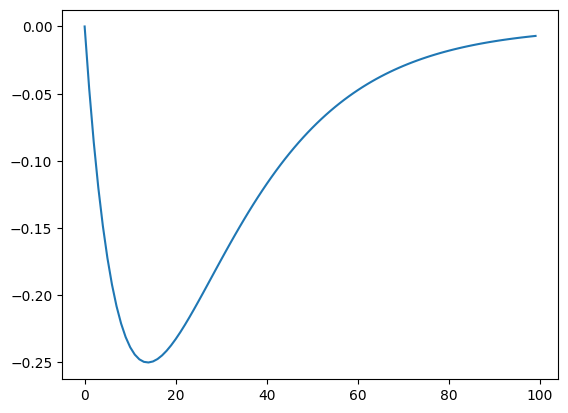

In [207]:
tau_rise = 20
tau_decay = 10
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
plt.plot(kernel)

**Example** Convolve with double exponential decay calcium transient (tau_rise=5, tau_decay=30) 

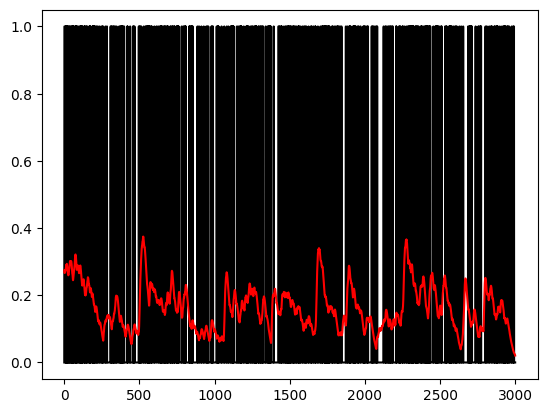

In [228]:
tau_rise = 5
tau_decay = 30
length = 100
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with double exponential decay calcium transient (tau_rise=20, tau_decay=20) 

Hint: Use unnormalized kernel for convolution.

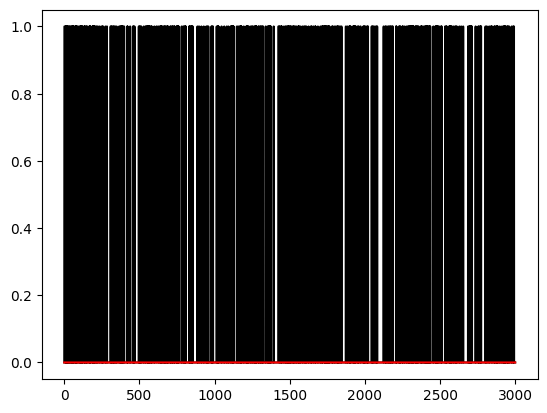

In [222]:
tau_rise = 20
tau_decay = 20
length = 100
t = np.arange(length)

kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with double exponential decay calcium transient (tau_rise=30, tau_decay=10) 

Hint: Use unnormalized kernel for convolution.

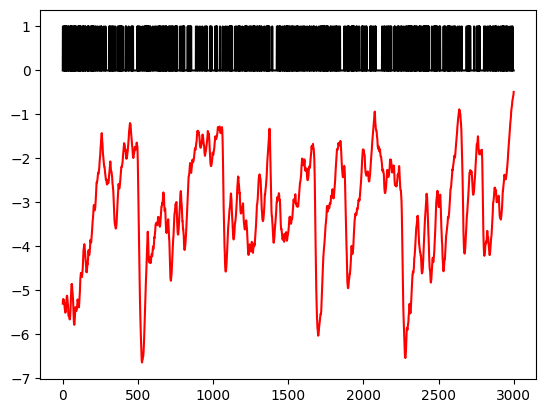

In [225]:
tau_rise = 30
tau_decay = 10
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

### Deconvolution using `scipy.signal.deconvolve`
In calcium imaging, the signal we observe is the calcium trace, but what we usually want to know is when the spikes happened. To estimate the spike train from the calcium signal, we use a method called deconvolution. In this section, you will use a simple function from the scipy library to try deconvolution. This gives you a basic way to go from the calcium trace back to an estimate of spike times.

In [48]:
n_points = 50  # Number of time steps
spike_train = np.random.binomial(1, 0.2, size=n_points)

<StemContainer object of 3 artists>

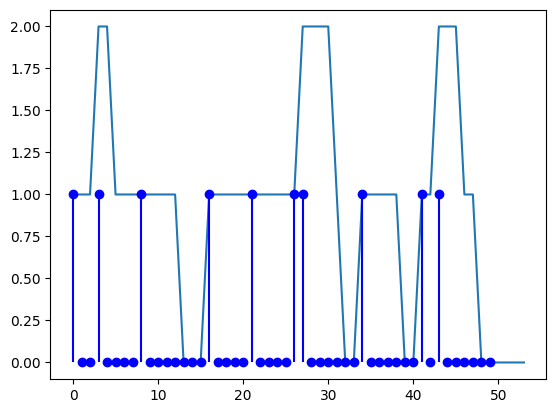

In [57]:
kernel = windows.boxcar(5)
calcium_trace = convolve(spike_train, kernel, mode='full')
estimated_spikes, _ = deconvolve(calcium_trace, kernel)

plt.plot(range(len(calcium_trace)), calcium_trace)
plt.stem(range(len(estimated_spikes)), estimated_spikes, basefmt=" ", linefmt='b-', markerfmt='bo')

<StemContainer object of 3 artists>

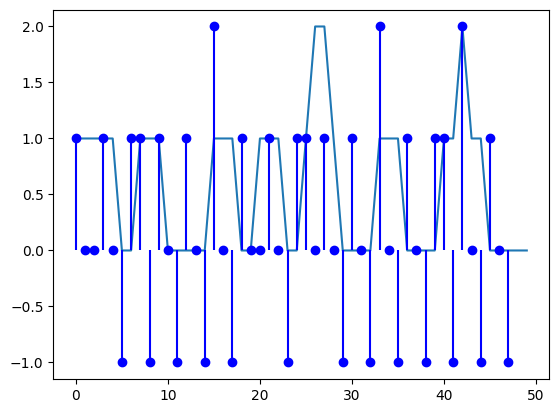

In [ ]:
kernel = windows.boxcar(3)
calcium_trace = convolve(spike_train, kernel, mode='full')
estimated_spikes, _ = deconvolve(calcium_trace, kernel)

plt.plot(range(len(calcium_trace)), calcium_trace)
plt.stem(range(len(estimated_spikes)), estimated_spikes, basefmt=" ", linefmt='b-', markerfmt='bo')

<StemContainer object of 3 artists>

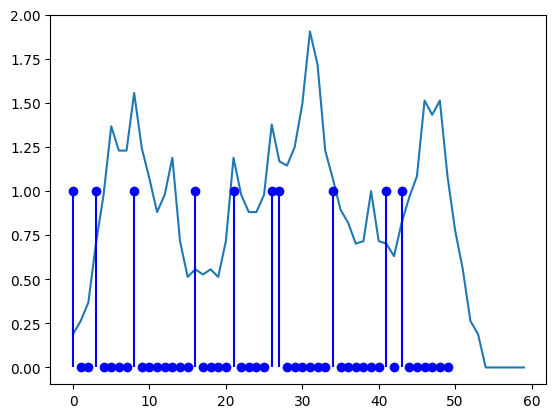

In [52]:
kernel = windows.exponential(11, tau=3.)
calcium_trace = convolve(spike_train, kernel, mode='full')
estimated_spikes, _ = deconvolve(calcium_trace, kernel)

plt.plot(range(len(calcium_trace)), calcium_trace)
plt.stem(range(len(estimated_spikes)), estimated_spikes, basefmt=" ", linefmt='b-', markerfmt='bo')

### AR(1) and AR(2) Models
In the last section, you will look at simple models that can describe how a calcium signal changes over time. These models are called AR(1) and AR(2). AR stands for "autoregressive", which means that the current value depends on the values before it. These models are often used in spike detection tools

In [26]:
# Spike train
spike_train = np.zeros(100)
spike_train[[10, 40, 70]] = 1

# AR(1) calcium model
c_ar1 = np.zeros_like(spike_train)
g1 = 0.9
for t in range(1, len(spike_train)):
    c_ar1[t] = g1 * c_ar1[t-1] + spike_train[t]

# AR(2) calcium model
c_ar2 = np.zeros_like(spike_train)
g1, g2 = 1.5, -0.7
for t in range(2, len(spike_train)):
    c_ar2[t] = g1 * c_ar2[t-1] + g2 * c_ar2[t-2] + spike_train[t]

<StemContainer object of 3 artists>

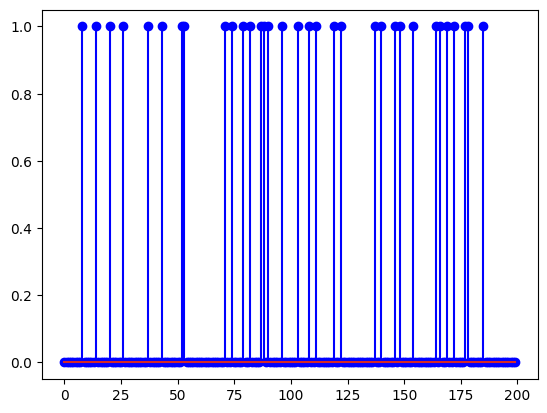

In [27]:
n_points = 200  # Number of time steps
decay_factor = 0.9  # AR(1) coefficient (how much the previous value influences the next)
spike_strength = 1.0  # Magnitude of calcium increase due to spikes
noise_std = 0.05  # Standard deviation of noise

# Generate spike train (random spikes with probability 0.2)
spike_train = np.random.binomial(1, 0.2, size=n_points)

plt.stem(range(n_points), spike_train, linefmt='b-', markerfmt='bo')